# General Fine-tuning Notebook
This notebook contains the code used to fine-tune general models and FinMoE

In [1]:
import torch
import pandas as pd
from functools import partial
from pathlib import Path
from datasets import Dataset, interleave_datasets
from peft import get_peft_model, LoraConfig, TaskType, PeftModel
from transformers import Trainer, TrainingArguments, AutoTokenizer, DataCollatorForLanguageModeling
from transformers.models.llama.modeling_llama import LlamaForCausalLM

from FinMoE import FinMoE, FinMoEConfig
from utils import DatasetArgs, get_dataset_args

assert torch.cuda.is_available(), "CUDA not available"
device = torch.device("cuda")

seed = 42
torch.manual_seed(seed)

MAX_LENGTH = 512
dataset_cache_path = Path(r"D:/datasets/general-3-tasks")

model_id = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [2]:
hub_basepath = Path(r"C:/Users/samba/.cache/huggingface/hub") ## MODIFY THIS PATH
args = get_dataset_args(tokenizer, hub_basepath)

## Load and Preprocess Dataset
Two preprocessing functions are provided for the two loss functions supported: ForCausalLM, and ForTokenClassification

In [ ]:
def train_preprocess_causal(args: DatasetArgs, dataset_id: str, example: dict):
    # Create prompt and target text
    prompt_args = [example[key] for key in args.prompt_args[dataset_id]]
    prompt = args.prompt_templates[dataset_id].format(*prompt_args)

    target = args.id2labels[dataset_id][example["label"]]
    full_text = prompt + target

    # tokenize text
    tokenized = tokenizer(full_text,
                          truncation=True,
                          padding="max_length",
                          max_length=MAX_LENGTH)
    
    # add padding tokens
    prompt_tokenized = tokenizer(prompt,
                              truncation=True,
                              max_length=MAX_LENGTH)
    prompt_length = len(prompt_tokenized["input_ids"])

    labels = tokenized["input_ids"].copy()
    labels[:prompt_length] = [-100] * prompt_length
    tokenized["labels"] = labels
    return tokenized

def train_preprocess_tokenclass(args: DatasetArgs, dataset_id: str, example: dict):
    # Create prompt and target text
    prompt_args = [example[key] for key in args.prompt_args[dataset_id]]
    prompt = args.prompt_templates[dataset_id].format(*prompt_args)

    # tokenize text
    tokenized = tokenizer(prompt,
                          truncation=True,
                          padding="max_length",
                          max_length=MAX_LENGTH)

    # tokenize and index label
    target = args.id2labels[dataset_id][example["label"]]
    token_target = tokenizer.encode(target, add_special_tokens=False)[0]
    label = args.token_list.index(token_target)
    tokenized["labels"] = label

    return tokenized

In [ ]:
nrows_list = [3876, 3876, 3876]
dataset_list = []
for i, (dataset_id, dataset_path) in enumerate(args.paths.items()):
    train_subset = pd.read_csv(dataset_path / "train.csv",
                                delimiter=args.del_mapping[dataset_id],
                                names=args.names_mapping[dataset_id],
                                nrows=nrows_list[i])

    preprocess_func = partial(train_preprocess_tokenclass, args, dataset_id)
    dataset_list.append(Dataset
                        .from_pandas(train_subset)
                        .map(preprocess_func, batched=False)
                        .remove_columns(args.columns[dataset_id]))

n_datasets = len(dataset_list)
train_dataset = interleave_datasets(dataset_list, 
                                    probabilities=[1/n_datasets]*n_datasets,
                                    seed=seed)

### Save Dataset

In [ ]:
save_path = dataset_cache_path.with_stem("finmoe-tokenclass_balanced-len512")
train_dataset.save_to_disk(save_path)

### Load Dataset

In [3]:
load_path = dataset_cache_path.with_stem("finmoe-tokenclass_balanced-len512")
train_dataset = Dataset.load_from_disk(load_path)

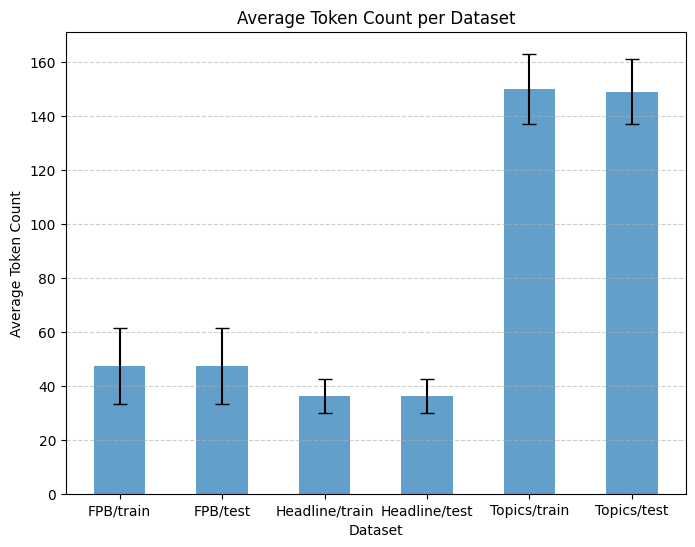

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Prepare lists to store statistics.
dataset_names = [f"{dataset_id}/{split_name}" for dataset_id in args.expert_order for split_name in ["train", "test"]]
mean_tokens_list = []
std_tokens_list = []

# Iterate over each dataset in your list.
for ds in dataset_list:
    # Assuming the dataset has a "text" column.
    token_counts = [len(example) for example in ds["input_ids"]]
    
    mean_tokens = np.mean(token_counts)
    std_tokens = np.std(token_counts)
    
    mean_tokens_list.append(mean_tokens)
    std_tokens_list.append(std_tokens)

# Create a bar chart with error bars.
plt.figure(figsize=(8, 6))
plt.bar(dataset_names, mean_tokens_list, yerr=std_tokens_list, capsize=5, alpha=0.7, width=0.5)
plt.xlabel("Dataset")
plt.ylabel("Average Token Count")
plt.title("Average Token Count per Dataset")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Training
Run only the cells of the type of model you want to train: General model or FinMoE

### General model trainer

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.01,
    target_modules=["q_proj", "v_proj"]
)

model_id = "meta-llama/Llama-3.2-1B"
base_model = LlamaForCausalLM.from_pretrained(model_id, torch_dtype="float16")

peft_model = get_peft_model(base_model, peft_config)
peft_model.print_trainable_parameters()

In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

out_dir = Path(rf"D:/models/general-Llama-3_2-1B") ## OUTPUT DIRECTORY
training_args = TrainingArguments(
    output_dir=str(out_dir),
    num_train_epochs=6,
    per_device_train_batch_size=2,
    learning_rate=1e-3,
    weight_decay=0.01,
    warmup_steps=1000,
    save_strategy="epoch",
    do_train=True,
)

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
)

### FinMoE trainer

In [ ]:
ckpt_base = Path(r"D:/models")
expert_ckpt_names = {"FPB": "checkpoint-best",
                     "Headline": "checkpoint-best",
                     "Topics": "checkpoint-best"}

## note: str() wraps path as Path objects are not json serializable
expert_ckpts = [str(ckpt_base / f"expert-Llama-3_2-1B-{expert_name}" / expert_ckpt_names[expert_name])
                for expert_name in args.expert_order]

finMoE_config = FinMoEConfig(
    # loss_type="ForCausalLM",
    loss_type="ForTokenClassification",
    num_labels=len(args.token_list),

    g_net_id="FastGating",
    expert_ckpts=expert_ckpts,
    token_list=args.token_list,
)

finMoE_model = FinMoE(finMoE_config).to(device)
print("Memory allocated:", torch.cuda.memory_allocated())
print("Trainable params:")
for name, params in finMoE_model.named_parameters():
    if params.requires_grad:
        print(name, params.shape)


## --- use data_collator when training with "ForCausalLM" loss
# data_collator = DataCollatorForLanguageModeling(
#     tokenizer=tokenizer, mlm=False
# )

out_dir = Path(rf"D:/models/FinMoE-fast-gating-v2") ## OUTPUT DIRECTORY
training_args = TrainingArguments(
    output_dir=str(out_dir),
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    learning_rate=1e-3,
    weight_decay=0.01,
    warmup_steps=128,
    logging_steps=32,
    save_strategy="epoch",
    do_train=True,
)

trainer = Trainer(
    model=finMoE_model,
    args=training_args,
    train_dataset=train_dataset,
    # data_collator=data_collator,
)

Memory allocated: 4953514496
Trainable params:
gate.w_gate.weight torch.Size([3, 2048])


### Train

In [ ]:
trainer.train()

# Eval

In [3]:
from evals import evaluate, evaluate_FinMoE, evaluate_FinMoE_weighted, load_eval_dataset

When evaluating a model on a task, modify the `dataset_id` variable with the dataset name you want to evaluate over

In [4]:
dataset_id = "Headline"
testset = load_eval_dataset(tokenizer, dataset_id, args)

Loading Headline dataset from AdaptLLM/finance-tasks


### Evaluate general checkpoint

In [5]:
ckpt_path = Path(r"D:/models/general-Llama-3_2-1B") / "checkpoint-best"
ckpt_path = Path(r"D:/models/expert-Llama-3_2-1B-Headline") / "checkpoint-best"

model_id = "meta-llama/Llama-3.2-1B"
base_model = LlamaForCausalLM.from_pretrained(model_id, torch_dtype="float16") #.to(device)
expert_model = PeftModel.from_pretrained(base_model, ckpt_path, torch_dtype="float16").eval().to(device)

In [ ]:
results = evaluate(expert_model, tokenizer,
                   testset,
                   guidance=True,
                   token_opts=args.token_opts[dataset_id])
print(results)

### Evaluate FinMoE checkpoint

In [ ]:
ckpt_path = Path(r"D:/models/FinMoE-fast-gating") / "checkpoint-3590"
finMoE_model = FinMoE.load_pretrained(ckpt_path).to(device).eval()

In [ ]:
results = evaluate_FinMoE(finMoE_model, tokenizer,
                          testset,
                          args.token_opts[dataset_id])
print(results)

In [ ]:
results = evaluate_FinMoE_weighted(finMoE_model,
                                   testset,
                                   dataset_id,
                                   args)
print(results)

Parameter counts:
- FinMoE = 1,238,376,448
- 1 adapter = 851,968
- llama  = 1,235,814,400
- w_gate = 6,144
- 1,235,814,400 + 851,968 * 3 + 6,144 == 1,238,376,448